In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(style="whitegrid")

In [3]:
train_df = pd.read_csv("train_loan_eligibility.csv")
test_df = pd.read_csv("test_loan_eligibility.csv")

In [4]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001535,Male,No,0,Graduate,No,3254,0.0,50.0,360.0,1.0,Urban,Y
1,LP001792,Male,Yes,1,Graduate,No,3315,0.0,96.0,360.0,1.0,Semiurban,Y
2,LP002443,Male,Yes,2,Graduate,No,3340,1710.0,150.0,360.0,0.0,Rural,N
3,LP002517,Male,Yes,1,Not Graduate,No,2653,1500.0,113.0,180.0,0.0,Rural,N
4,LP001894,Male,Yes,0,Graduate,No,2620,2223.0,150.0,360.0,1.0,Semiurban,Y


In [5]:
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001528,Male,No,0,Graduate,No,6277,0.0,118.0,360.0,0.0,Rural
1,LP002804,Female,Yes,0,Graduate,No,4180,2306.0,182.0,360.0,1.0,Semiurban
2,LP002945,Male,Yes,0,Graduate,Yes,9963,0.0,180.0,360.0,1.0,Rural
3,LP001784,Male,Yes,1,Graduate,No,5500,1260.0,170.0,360.0,1.0,Rural
4,LP001514,Female,Yes,0,Graduate,No,2330,4486.0,100.0,360.0,1.0,Semiurban


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             480 non-null    object 
 2   Married            488 non-null    object 
 3   Dependents         483 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      464 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         471 non-null    float64
 9   Loan_Amount_Term   479 non-null    float64
 10  Credit_History     448 non-null    float64
 11  Property_Area      491 non-null    object 
 12  Loan_Status        491 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 50.0+ KB


In [7]:
def clean_data(df):
    df['Dependents'] = df['Dependents'].replace('3+', 3).astype(float)
    for col in ['Gender', 'Married', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term']:
        df[col].fillna(df[col].mode()[0], inplace=True)
    df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
    df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
    return df

In [8]:
train_df = clean_data(train_df)

In [9]:
test_df = clean_data(test_df)

In [10]:
for df in [train_df, test_df]:
    df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']
    df['Balance_Income'] = df['Total_Income'] - (df['EMI'] * 1000)
    df['Income_to_Loan_Ratio'] = df['Total_Income'] / df['LoanAmount']
    df['LoanAmount_log'] = np.log(df['LoanAmount'])

In [11]:
categorical = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
le = LabelEncoder()
for col in categorical:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

In [12]:
train_df['Loan_Status'] = train_df['Loan_Status'].map({'Y': 1, 'N': 0})

In [13]:
train_df['Loan_Status']

0      1
1      1
2      0
3      0
4      1
      ..
486    1
487    1
488    1
489    1
490    1
Name: Loan_Status, Length: 491, dtype: int64

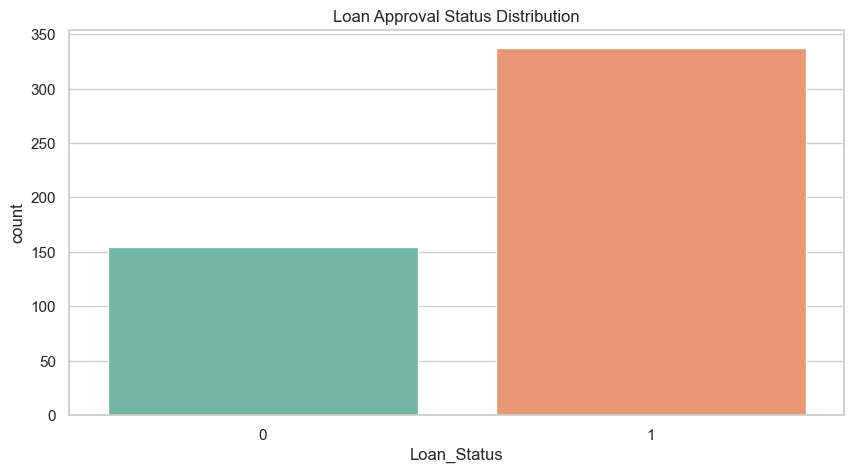

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='Loan_Status', palette='Set2')
plt.title("Loan Approval Status Distribution")
plt.show()

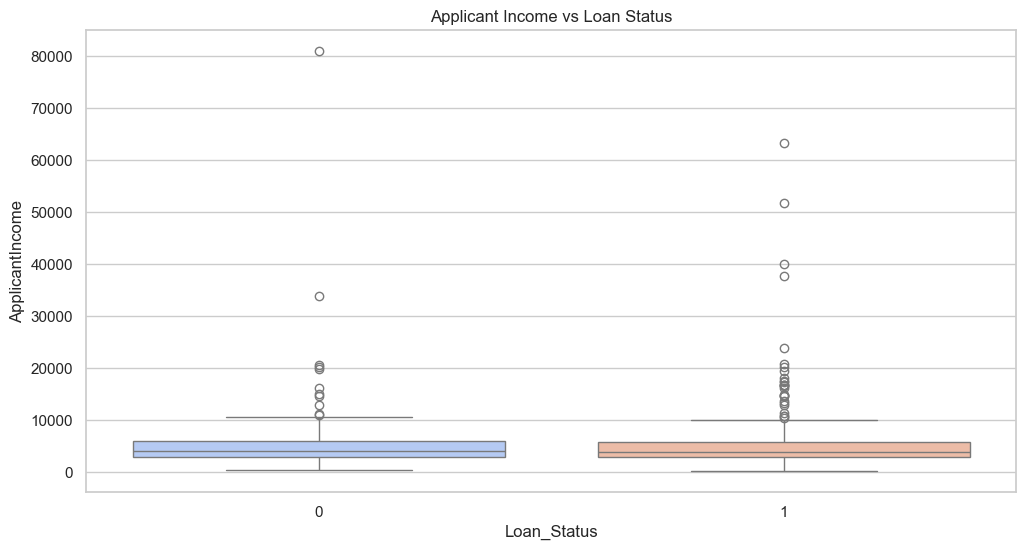

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='Loan_Status', y='ApplicantIncome', palette='coolwarm')
plt.title("Applicant Income vs Loan Status")
plt.show()

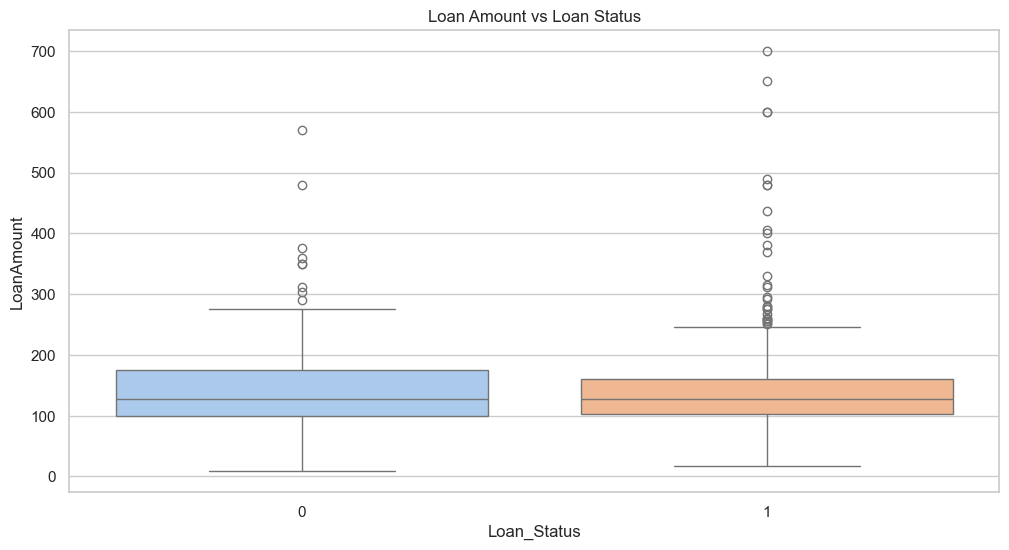

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='Loan_Status', y='LoanAmount', palette='pastel')
plt.title("Loan Amount vs Loan Status")
plt.show()

In [17]:
features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome',
            'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
            'Property_Area', 'Total_Income', 'EMI', 'Balance_Income', 'Income_to_Loan_Ratio', 'LoanAmount_log']


In [18]:
X = train_df[features]

In [19]:
y = train_df['Loan_Status']

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [21]:
scaler

StandardScaler()

In [22]:
rf = RandomForestClassifier(n_estimators=150, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

In [23]:
rf

RandomForestClassifier(max_depth=6, n_estimators=150, random_state=42)

In [24]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_val)

In [25]:
gb 

GradientBoostingClassifier(learning_rate=0.05, random_state=42)

In [26]:
print("Accuracy:", accuracy_score(y_val, rf_pred))

Accuracy: 0.8080808080808081


In [27]:
print("Precision:", precision_score(y_val, rf_pred))

Precision: 0.825


In [28]:
print("Recall:", recall_score(y_val, rf_pred))

Recall: 0.9295774647887324


In [29]:
print("F1 Score:", f1_score(y_val, rf_pred))

F1 Score: 0.8741721854304636


In [62]:
classification_report(y_val, rf_pred)

'              precision    recall  f1-score   support\n\n           0       0.74      0.50      0.60        28\n           1       0.82      0.93      0.87        71\n\n    accuracy                           0.81        99\n   macro avg       0.78      0.71      0.73        99\nweighted avg       0.80      0.81      0.80        99\n'

In [64]:
print("\n--- Gradient Boosting Metrics ---")
print("Accuracy:", accuracy_score(y_val, gb_pred))
print("Precision:", precision_score(y_val, gb_pred))
print("Recall:", recall_score(y_val, gb_pred))
print("F1 Score:", f1_score(y_val, gb_pred))
print(classification_report(y_val, gb_pred))


--- Gradient Boosting Metrics ---
Accuracy: 0.7878787878787878
Precision: 0.8289473684210527
Recall: 0.8873239436619719
F1 Score: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.65      0.54      0.59        28
           1       0.83      0.89      0.86        71

    accuracy                           0.79        99
   macro avg       0.74      0.71      0.72        99
weighted avg       0.78      0.79      0.78        99



In [66]:
rf_probs = rf.predict_proba(X_val)[:, 1]
gb_probs = gb.predict_proba(X_val)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_probs)
fpr_gb, tpr_gb, _ = roc_curve(y_val, gb_probs)

In [68]:
gb_probs

array([0.7968266 , 0.85586243, 0.83914259, 0.78188349, 0.71558781,
       0.83437075, 0.78518719, 0.062249  , 0.88415158, 0.70330358,
       0.64650165, 0.13979596, 0.09211452, 0.05106208, 0.71373156,
       0.63882009, 0.93233838, 0.9240136 , 0.72493216, 0.6276339 ,
       0.80357437, 0.81300692, 0.86309861, 0.04628623, 0.80814332,
       0.80479533, 0.92611243, 0.05523349, 0.82666869, 0.83410087,
       0.83410087, 0.89413396, 0.0591358 , 0.80276237, 0.79686059,
       0.88548475, 0.86326049, 0.73701692, 0.7911529 , 0.75386222,
       0.47690448, 0.51005731, 0.71582086, 0.52896465, 0.09459017,
       0.84416025, 0.0699127 , 0.92464044, 0.8570449 , 0.6843096 ,
       0.81381591, 0.76844931, 0.12532676, 0.09435957, 0.72493216,
       0.91366223, 0.69567535, 0.90741177, 0.88738926, 0.47056091,
       0.90717488, 0.90741177, 0.84919798, 0.93233838, 0.86926033,
       0.87367024, 0.4519277 , 0.68829419, 0.84092895, 0.83530422,
       0.8720688 , 0.77849358, 0.40616481, 0.83377048, 0.03740

In [70]:
rf_probs

array([0.72978149, 0.84205651, 0.766842  , 0.74157899, 0.68863049,
       0.70807214, 0.74369238, 0.20534238, 0.80793597, 0.70019673,
       0.68073941, 0.1834095 , 0.1139265 , 0.11029367, 0.78462166,
       0.62426318, 0.90007865, 0.90796908, 0.7041156 , 0.56544446,
       0.72123121, 0.82460072, 0.84720905, 0.2114964 , 0.81074914,
       0.73107694, 0.91915082, 0.12822025, 0.78551662, 0.76916058,
       0.76185531, 0.79466405, 0.11335402, 0.77476804, 0.78819213,
       0.89696205, 0.81375616, 0.69750149, 0.75124329, 0.69515918,
       0.61350983, 0.48968577, 0.68477836, 0.58727844, 0.1111822 ,
       0.77277278, 0.20171357, 0.90344392, 0.88149504, 0.63474355,
       0.90733177, 0.75436177, 0.12059137, 0.15760677, 0.65545666,
       0.91827539, 0.74512193, 0.87508407, 0.8415063 , 0.6641793 ,
       0.90070764, 0.86647779, 0.8697778 , 0.93373776, 0.7957335 ,
       0.86243739, 0.54709617, 0.76496307, 0.87217886, 0.73029806,
       0.81730503, 0.76638863, 0.68076017, 0.81726834, 0.12296

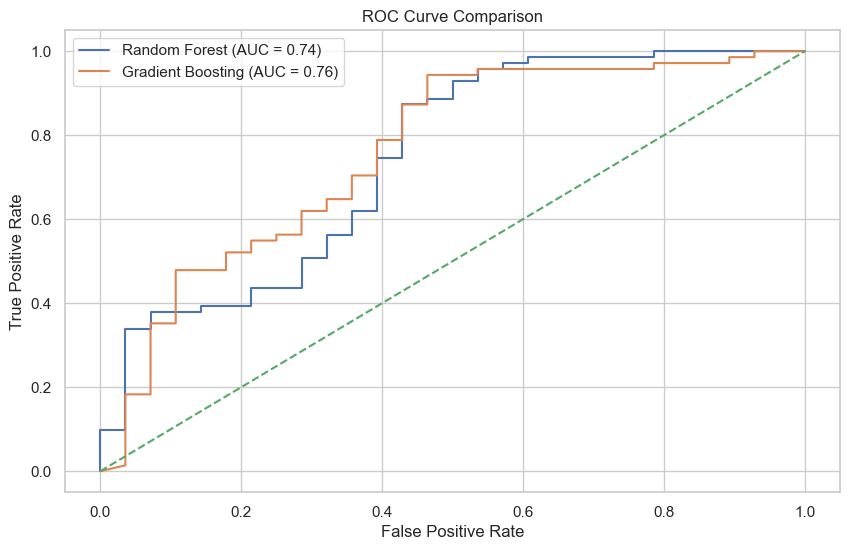

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_score(y_val, rf_probs))
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_score(y_val, gb_probs))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
X_test = test_df[features]
X_test_scaled = scaler.transform(X_test)
final_model = gb
final_test_pred = final_model.predict(X_test_scaled)
final_submission = pd.DataFrame({
    'Loan_ID': test_df['Loan_ID'],
    'Loan_Status': ['Y' if pred == 1 else 'N' for pred in final_test_pred]
})

In [76]:
final_submission.to_csv("submission.csv", index=False)

In [78]:
print("\n✅ Final submission file created: submission.csv")


✅ Final submission file created: submission.csv


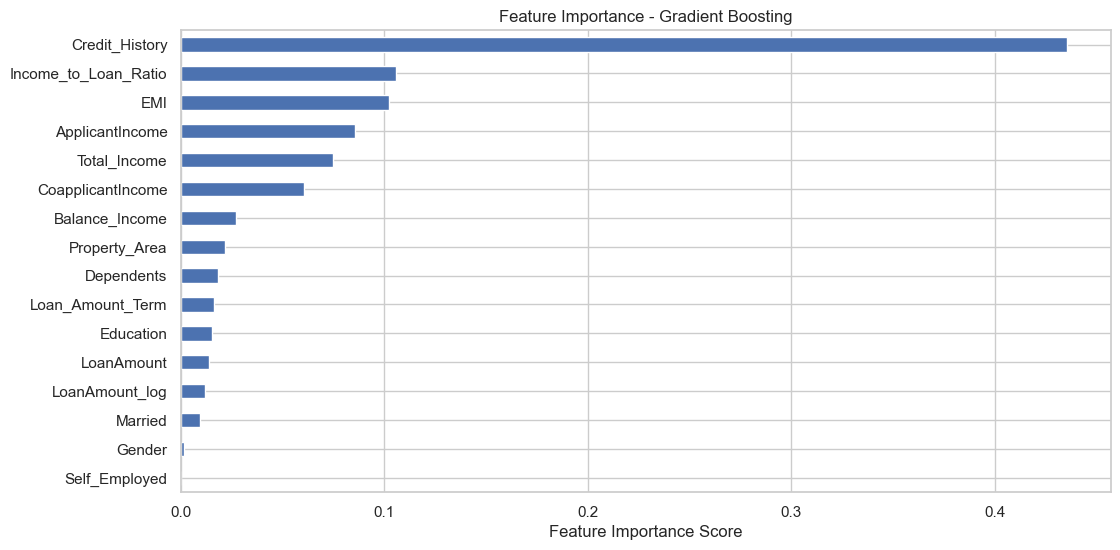

In [80]:
feat_imp = pd.Series(final_model.feature_importances_, index=features)
plt.figure(figsize=(12, 6))
feat_imp.sort_values(ascending=True).plot(kind='barh', title='Feature Importance - Gradient Boosting')
plt.xlabel('Feature Importance Score')
plt.show()

## --- Key Business Insights ---


#### Credit_History is the top determinant of loan approval (based on feature importance).
#### EMI and Balance_Income help gauge repayment ability and risk.
#### Education, Dependents, and Property_Area affect creditworthiness marginally.

## --- Strategic Recommendations ---


####  Integrate real-time scoring with Credit_History, Income-to-Loan Ratio, and EMI filters.
####  Reject or flag high-risk applications with low Credit_History or negative Balance Income.
#### Highlight borderline applicants for manual review with prediction confidence.
#### Implement dashboards tracking approval trends by location, income bands, and education.